Hello, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:
<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> if I can give some recommendations
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* Thank you for this work. It was interesting to check.
* The code is easy to read and understand. I was really surprised!
* Great that you've used your own wrappers!
* There is one thing that needs to be corrected in your project. It's a minor issue that is easy to fix.
* There are also some comments for improvement. They don’t mean that you’ve done anything wrong, but they’re things we wanted to point out that can help you further develop your skills.
* Submit a new version of the project as soon as it will be ready.


### <font color='orange'>General feedback (review 2)</font>
* Your corrections look great, you've improved your work significantly!
* Don't forget about simple models (e.g. Linear). Sometimes predicting speed is crucial. Also, they can be a good baseline.
* Your project has been accepted and now you can move on to the next sprint.
* Keep at it. You're improving every day! Good luck with further projects!

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# 1. Data preparation

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, plotting

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

<div class="alert alert-block alert-success">
<b>Success:</b> Very good that all imports are in the first cell!
</div>

### 1.1 First Glance

In [2]:
# import data and a first glance

data = pd.read_csv('/datasets/car_data.csv')
display(data.head(), data.shape)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


(354369, 16)

In [3]:
# show feature type

data.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Mileage               int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

In [4]:
display(data.describe(include='object').T, data.describe(exclude='object').T)

,count,unique,top,freq
DateCrawled,354369,15470,05/03/2016 14:25,66
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
NotRepaired,283215,2,no,247161
DateCreated,354369,109,03/04/2016 00:00,13719
LastSeen,354369,18592,07/04/2016 07:16,654


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


There are a couple of things we should notice befor proceed:
- We should exclude the DateCrawled right off the bat because its high cardinality and likely to cause overfitting.
- Not all categorical variables are filled with values, there are some NAs. 
- Categorical variable such as "Model" is likely to cause big increase in dimensions when preprocessing the data for xgb, so be mindful about that, we may need some other ways to do encoding. 
- By a first look, all numerical variables are relatively clean, there seems to have no NAs present.

<div class="alert alert-block alert-success">
<b>Success:</b> All required methods were used. The comments are very informative!
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> There is a problem with one numerical feature. Try to find it.
</div>

### 1.1 (New)
I found that the numerial feature 'NumberOfPictures' has interesting properties. Let's further confirm that this column only has 0 in it. If it does, then this is a good indicator that we should drop it since it has no use in future modeling process.

In [5]:
display(data['NumberOfPictures'].sum())
data.drop('NumberOfPictures', axis=1, inplace=True)

0

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Great!
</div>

### 1.2 Data Preprocessing

In [6]:
# make sure that numerical columns do no have any NA then drop the time variables

display([var for var in data.select_dtypes(exclude='object').columns if data[var].isnull().sum() > 0])
data.drop(['LastSeen','DateCreated','DateCrawled'], axis=1, inplace=True)

[]

<div class="alert alert-block alert-info">
<b>Improve: </b> I can't see the output of first line.
</div>

<div class="alert alert-block alert-success">
<b>Success:</b> Well done! These columns are useless.
</div>

In [ ]:
# since CATBoost can handle categorical variables automatically, we will prepare 
# a preprocessed data set just for the xgb and the LGBM model.

# lightgbm only supports categorical features encoded as non-negative int type less than Int32.MaxValue (2147483647).  
# it is best to use a contiguous range of integers started from zero
# otherwise, all negative values will be treated as missing values

data_special = data.copy()
label = 'Price'

# feature scaling and categorical encoding 

scaler = StandardScaler()
num_vars = [var for var in data_special.columns if data_special[var].dtypes != 'O']
num_vars.remove(label)
data_special[num_vars] = scaler.fit_transform(data_special[num_vars])

cat_vars = [var for var in data_special.columns if data_special[var].dtypes == 'O']
for each in cat_vars:
    data_special[each] = data_special[each].astype('category').cat.codes
    
data_special.head()

In [ ]:
# only prepare numerical features for the CatBoost model

scaler = StandardScaler()
data[num_vars] = scaler.fit_transform(data[num_vars])
for each in cat_vars:
    data[each].fillna('Missing', inplace=True)

<div class="alert alert-block alert-info">
<b>Improve: </b> Fitting scaler on all dataset is a sort of a data leak.
</div>

### 1.2 (New)
Let's split the data into train and test before any preprocessing. This is to prevent data leakage. After the split, we will perform preprocessing on each data sets individually.

In [7]:
# first train test split the data, since we have enough data, I will keep 20% as a hold out test set

train_set, test_set = train_test_split(data, test_size=.2)
train_set, val_set = train_test_split(train_set, test_size=.1)

print('train set shape is:', train_set.shape)
print('validation set shape is:', val_set.shape)
print('test set shape is:', test_set.shape)

train set shape is: (255145, 12)
validation set shape is: (28350, 12)
test set shape is: (70874, 12)


In [8]:
# Unlike previous, this time We will unify the preprocessing steps for all three models.

# lightgbm only supports categorical features encoded as non-negative int type less than Int32.MaxValue (2147483647).  
# it is best to use a contiguous range of integers started from zero. Otherwise, all negative values will be 
# treated as missing values.

label = 'Price'

# feature scaling and categorical encoding 

scaler = StandardScaler()
num_vars = [var for var in train_set.columns if train_set[var].dtypes != 'O']
num_vars.remove(label)
train_set[num_vars] = scaler.fit_transform(train_set[num_vars])

cat_vars = [var for var in train_set.columns if train_set[var].dtypes == 'O']
for each in cat_vars:
    train_set[each] = train_set[each].astype('category').cat.codes
    
display(train_set.head(), train_set.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
281327,5000,5,0.064655,1,-0.105982,173,-1.008293,-0.730202,2,38,0,-1.325192
270782,16500,0,0.109297,1,-0.578421,14,-2.855834,-0.461904,2,19,0,-0.126926
223940,6450,4,0.042335,1,0.208978,139,0.575313,1.147883,2,34,0,0.233171
384,400,-1,0.142778,1,-0.237215,83,0.575313,-0.730202,6,24,1,0.233249
115351,19999,0,0.075816,0,0.208978,99,-0.744359,-0.193606,2,27,0,-0.944721


(255145, 12)

In [9]:
# Validation set preprocessing

scaler = StandardScaler()
num_vars = [var for var in val_set.columns if val_set[var].dtypes != 'O']
num_vars.remove(label)
val_set[num_vars] = scaler.fit_transform(val_set[num_vars])

cat_vars = [var for var in val_set.columns if val_set[var].dtypes == 'O']
for each in cat_vars:
    val_set[each] = val_set[each].astype('category').cat.codes
    
display(val_set.head(), val_set.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
257218,1650,5,-0.005209,1,-0.300824,174,0.574164,0.352344,6,9,-1,0.953764
333650,3000,1,-0.096953,0,0.249514,20,0.574164,-0.986838,6,1,0,1.620294
20097,1750,-1,0.127311,1,-0.667716,132,0.574164,-0.183329,2,27,1,0.851775
77651,1900,5,-0.015403,1,-0.270250,171,0.574164,0.352344,6,38,-1,-0.937495
306408,0,7,-0.127535,1,-0.667716,-1,0.574164,-0.183329,6,38,1,1.829954


(28350, 12)

In [10]:
# Test set preprocessing

scaler = StandardScaler()
num_vars = [var for var in test_set.columns if test_set[var].dtypes != 'O']
num_vars.remove(label)
test_set[num_vars] = scaler.fit_transform(test_set[num_vars])

cat_vars = [var for var in test_set.columns if test_set[var].dtypes == 'O']
for each in cat_vars:
    test_set[each] = test_set[each].astype('category').cat.codes
    
display(test_set.head(), test_set.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
130643,11500,0,0.087199,1,-0.122291,116,-2.584819,-0.188582,6,38,0,-0.636009
346184,1300,5,-0.013722,1,-0.558487,147,0.573330,1.692831,6,27,0,-1.837435
138858,3650,2,-0.159496,1,0.095807,11,0.573330,0.348965,6,2,0,1.700164
334638,12000,1,-0.069789,1,0.420418,203,-2.847998,0.886511,6,20,0,1.107897
134172,6200,5,0.075985,1,-0.213588,205,-2.847998,0.617738,6,3,0,-0.864381


(70874, 12)

### 1.3 Train-Test Split

In [ ]:
# train test split

train_cat, test_cat = train_test_split(data, test_size=.15, random_state=0)
train_else, test_else = train_test_split(data_special, test_size=.15, random_state=0)

train_cat_x, train_cat_y = train_cat.drop('Price', axis=1), train_cat['Price']
train_else_x, train_else_y = train_else.drop('Price', axis=1), train_else['Price']

test_cat_x, test_cat_y = test_cat.drop('Price', axis=1), test_cat['Price']
test_else_x, test_else_y = test_else.drop('Price', axis=1), test_else['Price']

train_cat_x, val_cat_x, train_cat_y, val_cat_y = train_test_split(train_cat_x, train_cat_y, test_size=.1)
train_else_x, val_else_x, train_else_y, val_else_y = train_test_split(train_else_x, train_else_y, test_size=.1)

<div class="alert alert-block alert-info">
<b>Improve: </b> Well done! It's better to print sizes in this case. It will help to avoid some issues.
</div>

### 1.3 (New)
Now, since We have the train, val, and test sets preprocessed, I will convert each one to X feature sets and Y target sets.

In [11]:
train_y, train_x = train_set.Price, train_set.drop('Price', axis=1)
val_y, val_x = val_set.Price, val_set.drop('Price', axis=1)
test_y, test_x = test_set.Price, test_set.drop('Price', axis=1)

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Thank you for correcting improve comments!
</div>

# 2. Model training

### 2.1 Baseline Model

In [12]:
# baseline models

class CatboostWrapper(object):
    def __init__(self, estimator, seed=0, cat_features=None, params=None, metric=None):
        params['random_seed'] = seed
        params['eval_metric'] = metric
        self.estimator = estimator(**params)
        self.cat_features = cat_features

    def train(self, x_train, y_train, x_val, y_val):
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features) 
        self.estimator.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30, verbose=50)

    def predict(self, x):
        test_pool = Pool(x, cat_features=self.cat_features)
        return self.estimator.predict(x)
        
        
class LightGBMWrapper(object):
    def __init__(self, estimator, seed=0, cat_features=None, params=None, metric=None):
        params['random_state'] = seed
        self.estimator = estimator(**params, num_threads=-1)
        self.metric = metric
        self.cat_features = cat_features

    def train(self, x_train, y_train, x_val, y_val):
        self.estimator.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_val, y_val)],
                           eval_metric= self.metric, early_stopping_rounds=30, verbose=50, categorical_feature=self.cat_features)

    def predict(self, x):
        return self.estimator.predict(x)
    

class XgbWrapper(object):
    def __init__(self, estimator, seed=0, params=None, metric=None):
        params['random_state'] = seed
        self.estimator = estimator(**params)
        self.metric = metric

    def train(self, x_train, y_train, x_val, y_val):
        self.estimator.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_val, y_val)],
                           eval_metric= self.metric, early_stopping_rounds=30, verbose=50)

    def predict(self, x):
        return self.estimator.predict(x)

<div class="alert alert-block alert-success">
<b>Success:</b> Wow! It's awesome. Keep it up!
</div>

In [13]:
# fix number of iterations, then use default values for the rest parameters of each model

lightgbm_params = {'n_estimators':500}
xgb_params = {'n_estimators':500}
cat_params = {'iterations':500}

### 2.2 Training Time

In [14]:
%%time
SEED=123
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']
lg = LightGBMWrapper(LGBMRegressor, SEED, cat_vars, lightgbm_params, 'rmse')
lg.train(train_x, train_y, val_x, val_y)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 1809.49	training's l2: 3.27424e+06	valid_1's rmse: 2172.85	valid_1's l2: 4.72127e+06
[100]	training's rmse: 1726.03	training's l2: 2.97918e+06	valid_1's rmse: 2140.31	valid_1's l2: 4.58093e+06
[150]	training's rmse: 1682.5	training's l2: 2.83082e+06	valid_1's rmse: 2132.29	valid_1's l2: 4.54668e+06
Early stopping, best iteration is:
[146]	training's rmse: 1685.27	training's l2: 2.84013e+06	valid_1's rmse: 2131.11	valid_1's l2: 4.54164e+06
CPU times: user 15.8 s, sys: 82.5 ms, total: 15.9 s
Wall time: 16.1 s


In [15]:
%%time
SEED=123
xg = XgbWrapper(XGBRegressor, SEED, xgb_params, 'rmse')
xg.train(train_x, train_y, val_x, val_y)

[02:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5840.63	validation_1-rmse:5800.34
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[50]	validation_0-rmse:2218.87	validation_1-rmse:2259.56
[100]	validation_0-rmse:2073.22	validation_1-rmse:2123.37
[150]	validation_0-rmse:2014.55	validation_1-rmse:2082.34
[200]	validation_0-rmse:1978.77	validation_1-rmse:2059.21
[250]	validation_0-rmse:1949.27	validation_1-rmse:2037.94
[300]	validation_0-rmse:1927.17	validation_1-rmse:2025.32
[350]	validation_0-rmse:1908.72	validation_1-rmse:2013.4
[400]	validation_0-rmse:1894.08	validation_1-rmse:2006.36
[450]	validation_0-rmse:1880.76	validation_1-rmse:2001.45
[499]	validation_0-rmse:1869.47	validation_1-rmse:1998.57
CPU times: user 1min 58s, sys: 99.7 ms, total: 1min 58s
Wall time: 1min 59s


In [16]:
%%time
SEED=123
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']
cat = CatboostWrapper(CatBoostRegressor, SEED, cat_vars, cat_params, 'RMSE')
cat.train(train_x, train_y, val_x, val_y)

0:	learn: 4431.0584241	test: 4415.1982942	best: 4415.1982942 (0)	total: 1.14s	remaining: 9m 26s
50:	learn: 2489.8711920	test: 2527.9960515	best: 2527.9960515 (50)	total: 50.1s	remaining: 7m 21s
100:	learn: 2128.0206646	test: 2216.6169884	best: 2216.6169884 (100)	total: 1m 33s	remaining: 6m 10s
150:	learn: 2026.1620672	test: 2117.9442466	best: 2117.9442466 (150)	total: 2m 20s	remaining: 5m 24s
200:	learn: 1980.5527091	test: 2078.0869809	best: 2078.0869809 (200)	total: 3m 7s	remaining: 4m 39s
250:	learn: 1948.0042980	test: 2056.2979704	best: 2056.2979704 (250)	total: 3m 52s	remaining: 3m 50s
300:	learn: 1921.8055805	test: 2042.2647489	best: 2042.2647489 (300)	total: 4m 38s	remaining: 3m 4s
350:	learn: 1902.5102592	test: 2032.2785888	best: 2032.2785888 (350)	total: 5m 24s	remaining: 2m 17s
400:	learn: 1885.7009511	test: 2024.3443820	best: 2024.0954608 (399)	total: 6m 11s	remaining: 1m 31s
450:	learn: 1869.9240601	test: 2020.0866210	best: 2020.0866210 (450)	total: 6m 59s	remaining: 45.6s
4

From observation, we noticed that while the catboost model takes the longest to train, it is the most accuracy model among all models. In the next step, we will use the test set to determine which model has better overall performance on unseen data.

<div class="alert alert-block alert-success">
<b>Success:</b> Great!
</div>

### 2.3 Prediction Accuracy

In [17]:
lg_pred = lg.predict(test_x)
xg_pred = xg.predict(test_x)
cat_pred = cat.predict(test_x)

lg_result = np.sqrt(mean_squared_error(test_y, lg_pred))
xg_result = np.sqrt(mean_squared_error(test_y, xg_pred))
cat_result = np.sqrt(mean_squared_error(test_y, cat_pred))

print('RMSE for LightGBM Regressor: %.3f' % lg_result)
print('RMSE for XGB Regressor: %.3f' % xg_result)
print('RMSE for CatBoost Regressor: %.3f' % cat_result)

RMSE for LightGBM Regressor: 1996.423
RMSE for XGB Regressor: 1940.317
RMSE for CatBoost Regressor: 1967.250


It seems that all three models have similar performance. As a result of this, I will pick the lightgbm model for the interest of shorter training duration. I will also choose a catboost model to make comparison in terms of performance and tuning duration.

### 2.4 CatBoost Hyperparameter Tuning

In [ ]:
# I tried to do some tuning by using the randomized_search function provided by Catboost, but unfortunately given the size of 
# our data, the kernel always died near the every end of the process.

cat_tuned = CatBoostRegressor(iterations=200)
temp = Pool(train_cat_x, train_cat_y, cat_features=cat_vars)

params = {'l2_leaf_reg': list(np.linspace(1.0, 30.0, 50)),
          'subsample': list(np.linspace(0.5, 1.0, 50)),
          'depth': list(np.linspace(3, 16, 14)),
          'colsample_bylevel': list(np.linspace(0.5, 1.0, 50))}

cat_tuned_result = cat_tuned.randomized_search(params, temp, cv=3, n_iter=5, plot=True)
del temp

### 2.5 LightGBM Hyperparameter Tuning

In [ ]:
params = {'l2_leaf_reg': list(np.linspace(1.0, 30.0, 50)),
          'subsample': list(np.linspace(0.5, 1.0, 50)),
          'depth': list(np.linspace(3, 16, 14)),
          'colsample_bylevel': list(np.linspace(0.5, 1.0, 50))}

lg_tuned_result = RandomizedSearchCV(estimator=LGBMRegressor(n_estimators=200), param_distributions=params, 
                                     n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
lg_tuned_result.fit(train_else_x, train_else_y)
lg_tuned_result.best_params_, lg_tuned_result.best_score_

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please, output the time required for training tunned models, their accuracy, and compare them.
    <br> Select one model and explain your choice.
</div>

### 2.4 (New)
I will do a bayesian optimization for a lightgbm and a catboost model

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Wow! It's very rare but interesting technique. 
</div>

In [ ]:
#pip install hyperopt

In [33]:
import time
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

lgb_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 600, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 1)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 20.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 20.0),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 20, 100, 5)),
}

xgb_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 600, 1)),
    'max_depth': scope.int(hp.quniform("max_depth", 5, 20, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'gamma': hp.uniform ('gamma', 1.0, 50.0),
    'reg_alpha' : hp.uniform('reg_alpha', 0.0, 20.0),
    'reg_lambda' : hp.uniform('reg_lambda', 0.0, 20.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 100, 1)),
    }

cat_space = {
    'iterations': scope.int(hp.quniform('iterations', 200, 600, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'depth': scope.int(hp.quniform("depth", 5, 16, 1)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.0, 20.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.6, 1.0),
    #'min_child_samples': scope.int(hp.quniform('min_child_samples', 20, 100, 5)),
    #'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 1))
}

In [32]:
def hyperopt(estimator, param_space, X_train, y_train, X_test, y_test, num_eval, eval_metric=None):
    
    start = time.time()
    
    def objective_function(params):
        model = estimator(**params)
        score = cross_val_score(model, X_train, y_train, cv=3, scoring=eval_metric).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    
    if str(estimator) == "<class 'lightgbm.sklearn.LGBMRegressor'>":
        
        for each in ['num_leaves','max_depth','n_estimators','min_child_samples']:
            best_param[each] = int(best_param[each])
        
        model_best = estimator(**best_param)     
        model_best.fit(X_train, y_train)
        y_pred = model_best.predict(X_test)
        
    
    if str(estimator) == "<class 'xgboost.sklearn.XGBRegressor'>":
         
        for each in ['n_estimators','max_depth','min_child_weight']:
            best_param[each] = int(best_param[each])
                
        model_best = estimator(**best_param)     
        model_best.fit(X_train, y_train)
        y_pred = model_best.predict(X_test)
        
    
    if str(estimator) == "<class 'catboost.core.CatBoostRegressor'>":
         
        for each in ['iterations','depth']:#,'min_child_samples','num_leaves']:
            best_param[each] = int(best_param[each])
                
        model_best = estimator(**best_param)     
        model_best.fit(X_train, y_train)
        test_pool = Pool(X_test)
        y_pred = model_best.predict(test_pool)

    
    print("")
    print("##### Results #####")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    
    return trials

In [35]:
num_eval=20
eval_metric = 'neg_mean_squared_error'
lgb_hyperopt = hyperopt(LGBMRegressor, lgb_space, train_x, train_y, val_x, val_y, num_eval, eval_metric)

100%|██████████| 20/20 [11:27<00:00, 34.36s/trial, best loss: 2991225.620955284]

##### Results #####
Score best parameters:  -2991225.620955284
Best parameters:  {'bagging_fraction': 0.992372845290391, 'colsample_by_tree': 0.7411501249206709, 'learning_rate': 0.14687721143940655, 'max_depth': 15, 'min_child_samples': 55, 'n_estimators': 312, 'num_leaves': 84, 'reg_alpha': 0.2689810101826029, 'reg_lambda': 16.607980244145754}
Test Score:  1900.305361783434
Time elapsed:  697.6875789165497
Parameter combinations evaluated:  20


<div class="alert alert-block alert-info">
<b>Improve (review 2): </b> Other growing strategies are much more slower than symmetric. That's why they are not available on CPU yet.
</div>

In [34]:
# please note that the option for tuning 'min_child_samples' and 'num_leaves' is not avaliable by using symmetric trees as growing policy. 
# To use it we would need to set tree growing strategy to something else other than symmetric. 
# However, other growing policies are supported only on GPU for now.

num_eval=10    # since catboost model takes longer to train, we will give less trails to run for the hyper-tuning
eval_metric = 'neg_mean_squared_error'
cat_hyperopt = hyperopt(CatBoostRegressor, cat_space, train_x, train_y, val_x, val_y, num_eval, eval_metric)

0:	learn: 4091.5332347	total: 123ms	remaining: 43.4s  

1:	learn: 3739.4060287	total: 316ms	remaining: 55.5s  

2:	learn: 3444.4380696	total: 599ms	remaining: 1m 9s  

3:	learn: 3193.9666125	total: 801ms	remaining: 1m 9s  

4:	learn: 2991.4516500	total: 1s	remaining: 1m 9s     

5:	learn: 2831.1588880	total: 1.2s	remaining: 1m 9s   

6:	learn: 2687.3985105	total: 1.48s	remaining: 1m 13s 

7:	learn: 2575.6380036	total: 1.69s	remaining: 1m 12s 

8:	learn: 2483.7654596	total: 1.89s	remaining: 1m 12s 

9:	learn: 2400.3791812	total: 2.09s	remaining: 1m 11s 

10:	learn: 2337.5840496	total: 2.37s	remaining: 1m 13s

11:	learn: 2285.2460533	total: 2.58s	remaining: 1m 13s

12:	learn: 2237.6722215	total: 2.86s	remaining: 1m 14s

13:	learn: 2198.5442335	total: 3.06s	remaining: 1m 14s

14:	learn: 2168.1763031	total: 3.27s	remaining: 1m 13s

15:	learn: 2136.2006195	total: 3.54s	remaining: 1m 14s

16:	learn: 2108.3394282	total: 3.75s	remaining: 1m 14s

17:	learn: 2089.4725994	total: 4.05s	remaining: 

We observe that the catboost model used 5 times longer time to train while only achieving slightly better rmse results. Due to this reason, I will choose the lightgbm model to do a final modeling fitting and feature importance.

### 2.5 (New) LightGBM Model Final Fitting

In [111]:
%%time

# prepare the final data

x = pd.concat([train_x, val_x], axis=0)
y = pd.concat([train_y, val_y], axis=0)
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']

# unpack the selected parameters

unpack_function = lambda l: [item for sublist in l for item in sublist]
unpack_all = lgb_hyperopt.best_trial['misc']['vals']
unpack_values = [i for i in unpack.values()]
values = unpack_function(unpack_values)
keys = [i for i in unpack.keys()]
best_param = {keys[i]: values[i] for i in range(len(keys))} 

for each in ['num_leaves','max_depth','n_estimators','min_child_samples']:
    best_param[each] = int(best_param[each])

lgb = LGBMRegressor(**best_param)
lgb.fit(x, y, eval_set = [(x, y)], eval_metric= 'rmse', early_stopping_rounds=30, verbose=50, categorical_feature=cat_vars)

Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 1680.72	training's l2: 2.82483e+06
[100]	training's rmse: 1602.75	training's l2: 2.5688e+06
[150]	training's rmse: 1559.88	training's l2: 2.43321e+06
[200]	training's rmse: 1524.74	training's l2: 2.32483e+06
[250]	training's rmse: 1496.29	training's l2: 2.23887e+06
[300]	training's rmse: 1471.1	training's l2: 2.16414e+06
Did not meet early stopping. Best iteration is:
[312]	training's rmse: 1466.67	training's l2: 2.15112e+06
CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 11 s


LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_by_tree=0.7411501249206709, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.14687721143940655,
              max_depth=15, min_child_samples=55, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=312, n_jobs=-1, num_leaves=84,
              objective=None, random_state=None, reg_alpha=0.2689810101826029,
              reg_lambda=16.607980244145754, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [112]:
# final prediction and results

lgb_pred = lgb.predict(test_x)
lgb_result = np.sqrt(mean_squared_error(test_y, lgb_pred))
print('The final RMSE for a LightGBM Regressor is: %.3f' % lgb_result)

The final RMSE for a LightGBM Regressor is: 1859.450


We can see from this result that we are able to bringing down the rmse loss from 1996 to 1859 by spend very little time. The estimated training duration is less than 30s for a lightgbm model when train set and validation set are combined.  

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> You've done a hard work here!
</div>

# 3. Model analysis

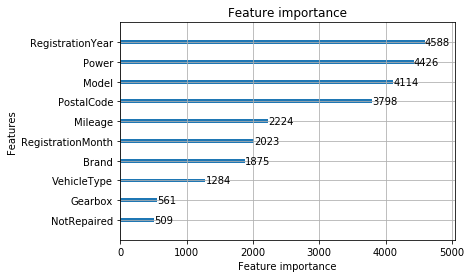

In [113]:
plotting.plot_importance(lgb, max_num_features=10)

<div class="alert alert-block alert-success">
<b>Success:</b> Very good that you've visualized feature importance!
</div>

## Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed